# 3D Reconstruction: Armadillo and Stereo Vision
**Robotics and Machine Vision, Online MSc in Artificial Intelligence, University of Bath** <br>  
Assignment author: Nadejda Roubtsova, 2023 <br>
Last revised for September - October 2023

Please note that the assignment is **not autograded**. 
So, please write your answers to the theoretical questions in **markdown cells** and provide implementations of algorithmic solutions in **code cells**. <br>

The marking of theoretical explanations will be strict looking for sound terminology use and well articulated arguments. The answers must be written fully in your own words. <br>

**Unless explicitly stated otherwise for a specific task,** you may (and should) use the *opencv-python* library, with possibly the *opencv-python-contrib* extension.


### **Question 1: Data loading and visualisation - 5 points** 
In the code cell below, load from file the camera calibration matrices for the stereo pair. Then load the two Armadillo images provided and visualise them simultaneously in two separate windows titled **Left Image** and **Right Image**. <br>

A suggestion:

Use the following to avoid kernel freezes. 

cv2.waitKey(0) <br>
cv2.destroyAllWindows()

When using the command sequence above, pressing **0** will neatly close and destroy both windows.


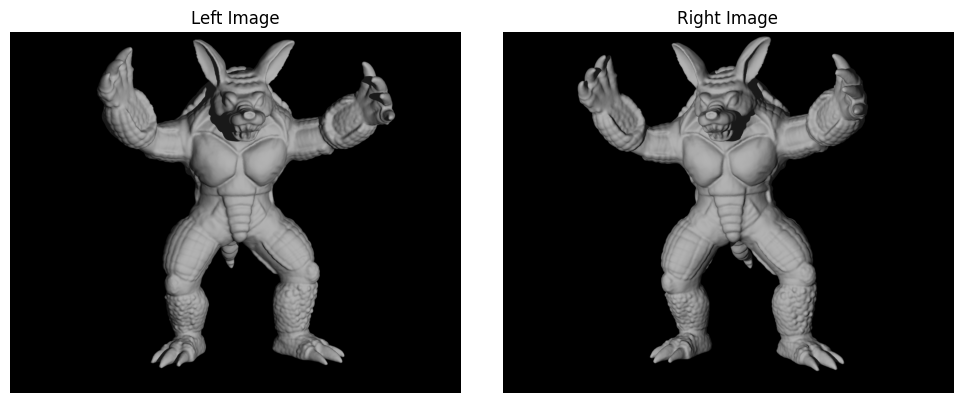

In [9]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def read_projection_txt(path: Path) -> np.ndarray:
    # Read projection matrix from text file
    rows = []
    with path.open() as f:
        for line in f:
            # Extract numeric values from each line
            nums = [float(x) for x in line.split() if x.strip()]
            if len(nums) >= 3:
                rows.append(nums)
    return np.asarray(rows, dtype=np.float64)

# Set base directory and read calibration matrices
base_dir = Path(".")
P_left = read_projection_txt(base_dir / "calib_1_left.txt")
P_right = read_projection_txt(base_dir / "calib_1_right.txt")
K_left = P_left[:, :3]  # Extract camera matrix
K_right = P_right[:, :3]

# Load stereo image pair
img_left = cv2.imread(str(base_dir / "armadillo_1_left.png"), cv2.IMREAD_COLOR)
img_right = cv2.imread(str(base_dir / "armadillo_1_right.png"), cv2.IMREAD_COLOR)

# Convert BGR to RGB for matplotlib display
left_rgb = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
right_rgb = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

# Create figure with two subplots
plt.rcParams["figure.figsize"] = (10, 4)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(left_rgb); ax[0].set_title("Left Image"); ax[0].axis("off")
ax[1].imshow(right_rgb); ax[1].set_title("Right Image"); ax[1].axis("off")
plt.tight_layout()
plt.show()

### **Question 2: Understanding the ply format for mesh representation - 10 points**<br>
Please go to the online **Stanford 3D Scanning Repository** of the **Stanford Computer Graphics Laboratory** at http://graphics.stanford.edu/data/3Dscanrep/ to download the 3D Model of **Armadillo**. The file is *Armadillo.ply.gz* (4MB when compressed) under **Armadillo** -> "Vripped reconstruction:". 

The model first appeared in:<br>
Venkat Krishnamurthy and Marc Levoy, **Fitting Smooth Surfaces to Dense Polygon Meshes**, Computer Graphics (SIGGRAPH 1996 Proceedings) <br>

The model is made freely available by the **Stanford Computer Graphics Laboratory** for non-commercial research purposes and has featured in numerous publications. In downloading the model, you agree to abide by the terms of use under "Please acknowledge.." on the **Stanford 3D Scanning Repository** webpage.

The 3D model is in the ply format, the binary encoding. You can open the Armadillo mesh in *Meshlab* (a free cross-platform 3D viewer: https://www.meshlab.net/). To enable you to complete this assignment, you need to convert to the ply format in *plain text*. This is easily done in Meshlab: open the original mesh in Meshlab, choose "export mesh as", choose a name and then, when the configuration window pops up, untick "binary encoding" before saving. The mesh will be saved in plain text, which you can open in any text editor (the size will be about 12 MB).

Your task in Question 2 is to research the ply mesh format online and ways to visualise it. In the markdown cell below, explain the ply format and how the surface is represented. Define at least the terms *vertex*, *face* and *normal* (this may or may not be present) as part of your description. Specify how the various properties of the given mesh (e.g. resolution) are defined in terms of these parameters (refer to the actual mesh parameters). The explanation must be in your own words. You may use *self-drawn* diagrams and screenshots to help you answer the question.<br>

Present a snapshot of the mesh surface from a suitable 3D viewer. Bonus points if you can visualise vertices and faces superimposed onto the surface.

The best answer would cover the format systematically, in technically sound terms and references to examples, yet succinctly.

### Question 2

172974 verticies
345944 faces

### **Question 3:  3D point reprojection onto images (with basic occlusion handling) - 15 points**
In this question, you are asked to use the camera calibration matrix to project 3D points of Armadillo onto one of the images provided (it does not matter which one you choose **left** or **right**). Bear in mind that you want to project only the camera-facing 3D points of the model, **not** those under self-occlusion such as those from the back of the Armadillo. However, the occlusion handling mechanism you employ in your solution may be approximate, with simplifying assumptions. You need to also downsample the set of projected points, sampling from all parts of the model's camera-facing side (the Armadillo's front), rather than just one part - that's what is meant in the marking scheme by "evenly spatially distributed". <br>

Start by writing a ply (plain text) parsing function to read the Armadillo model. This does not have to be a generic ply parser implementation (you can tailor it specifically to the Armadillo ply file). The parser will only be run with the Armadillo mesh. You may also use third-party libraries for parsing the model (provided you understand what you are doing).

**Please do not submit the Armadillo model (converted to plain text or otherwise) with your assignment. The marker will have the plain text version of the Armadillo model obtained using Meshlab as described above to test your implementation if necessary.**  <br>

Write the cloud of 3D points selected for projection to a ply file. If the cloud is written to file correctly, you should be able to open and view it in Meshlab. Also, visualise your projected points in an image and save the image to file.  Submit **both** the  **point cloud** and the **image with projected points** with your assignment as evidence that your projection and occlusion handling/filtering code works correctly.

It may be useful to implement a function for writing a point cloud to a ply file already at this stage as you will need this functionality later on in this assingment again.

In [2]:
# Write your code for question 3 here

### **Question 4: Feature detection and matching in stereo reconstruction - 30 points**

For the stereo pair of Armadillo images provided, find a suitable algorithm pipeline for stable keypoint detection and establishing corresponding feature pairs. You may use the opencv library with the contributor extension, however we want to make sure you fully understand what the detector and matcher functions are doing. Hence, in the first part of the question please explain in your own words and correct terminology the theoretical background and implementational details (e.g. parameter setting) of your methodology. Show evidence of reading (beyond online blogs and OpenCV documentation) to research the method, providing references. The explanation is worth **15 points**.<br>

Next, provide the implementation of the pipeline in code. You need to provide a suitable visualisation of feature pairs matched in the stereo pair to verify the performance and to demonstrate that your approach works. Think about suitably ranking the feature matches by quality as you will use them in the next question, and present the ranking as part of your visualisation. The implementation with supporting visualisation is worth **15 points**.



**Write the explanation of your feature detection and matching pipeline here**

In [3]:
# Write your code for question 4 here

### **Question 5: Triangulation for 3D point stereo reconstruction - 40 points**

Triangulate any good matches found in the stereo pair of images to reconstruct 3D point positions. You are encouraged to implement triangulation by the method of ray backprojection and (approximate) intersection finding. You may choose another triangulation approach from literature instead, however you must code it yourself, **without** the use of available third-party implementations such as in OpenCV. Please, also run your triangulation implementation on the test point pair provided below and print the result for the marker to validate.

If you haven't already in Q3, write a function to export the reconstructed 3D keypoints as a point cloud in the ply format (the resultant ply file should be part of your submission for this assignment). Include the **3D positions of the two cameras** in the same point cloud file as points with indices 0 and 1.

Open the ply file together with the Armadillo groundtruth mesh. What can you say about the correctness of the reconstructed 3D points? Discuss and analyse the performance of your 3D point reconstruction algorithm as a whole. You may need to refer to the choices made in feature detection and matching. 

Produce suitable outputs to validate reconstruction. As a minimum, reproject the triangulated points back onto the images for validation.  For the assignment submission, you need to write both images to file with the reprojections clearly shown. Submit the images as part of your assignment, along with any additional validation outputs produced, combined with the reprojections in the images or separately.

**To summarise, for credit in Q5 you need to:**
1. Explain your triangulation approach with the necessary mathematical background. You should not rely on in-code comments for your explanation. Discuss and analyse your pipeline and its performance. This writing part is worth **20 points**.


2. Implement the algorithm without using any existing library function. Validate the implementation using the test point pair provided. Provide the requested outputs for the reconstruction pipeline: the point cloud of triangulated 3D points, reprojections of triangulated points and any additional outputs to demonstrate performance of your pipeline. The quality of your 3D point cloud will be also taken into account. This implementation part is worth **20 points**.


**Write the explanation of your triangulation approach for 3D stereo point reconstruction here. The explanation must include all necessary mathematical derivations. Use Latex for proper Maths rendering.**

In [4]:
# Write your code for question 5 here

In [5]:
# Run your triangulation implementation on the test point pair below and print the resultant 3D point
# Left point pixel coordinates: (679.8, 236.2)
# Right point pixel coordinates: (591.7, 236.2)

**Discuss and analyse your entire 3D point reconstruction pipeline here**

### **Bonus question (optional): Armadillo stereo image pair - 5 points**

This question is a bonus, outside of the 100 points total of this assignment: i.e., you won't lose points for not answering, but a correct answer would give a 5 point bonus award.

There is something atypical for stereo reconstruction about the image pair used in the assignment. Name what it is if you can recongise it by observing the image pair and state why the circumstance can complicate the stereo reconstruction task. The question does not require a long answer - a couple of sentences would suffice to express the point.

**Write the answer to the optinal bonus question here**